# Recommender Systems

In this lab, we'll be using Keras to build a recommender system. We'll be using the MovieLens dataset, a common benchmark dataset for recommender systems. 

MovieLens is a web-based recommender system and virtual community that recommends movies for its users to watch, based on their film preferences using collaborative filtering of members' movie ratings and movie reviews. You can check out the website here: https://movielens.org/

We will download a subset of the dataset containing 100k ratings. There are tens of millions of ratings in the full dataset, spanning hundreds of thousands of users and movies. The subset we'll be using is a good example to demonstrate the concepts in this lab.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
from urllib.request import urlretrieve
from pathlib import Path

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = Path("ml-100k.zip")
ML_100K_FOLDER = Path("ml-100k")

if not ML_100K_FOLDER.exists():
    if not ML_100K_FILENAME.exists():
        urlretrieve(ML_100K_URL, ML_100K_FILENAME.name)
    with ZipFile(ML_100K_FILENAME.name) as zip_file:
        zip_file.extractall()

The goal of MovieLens is to enable models to predict the rating a user would give to a movie they have not yet watched. This is a classic example of a recommendation system. The dataset is huge, and contains many parts giving information about the movies, the users, and the ratings. To begin with, we will look at the ratings file. Each line in the ratings file (u.data) is formatted as:

`user_id, item_id, rating, timestamp`

Which tells us a single user's rating of a single movie.

We will start by loading the ratings data into a pandas dataframe and then take a look at the first few rows. If you haven't used Pandas before, it's an extremely powerful library for dealing with tabular data. You can think of it as a Python version of Excel.

In [2]:
import pandas as pd

raw_ratings = pd.read_csv(ML_100K_FOLDER / "u.data", sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


The second file we'll look at is the movie metadata. This file (u.item) contains information about each movie, including the title and release date. Each line in the file is formatted as:

`movie_id | movie_title | release_date | video_release_date | IMDb_URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western`

As you can see, the genres are binary variables. As with one-hot encoding, a 1 indicates that the movie is of that genre, and a 0 indicates that it is not. We aren't going to work with the genre data in this lab, but it's easy to imagine that it could be useful in a real-world recommendation system.

In [3]:
columns_to_keep = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(ML_100K_FOLDER / "u.item", sep='|', names=columns_to_keep,
                    encoding='latin-1', usecols=range(5))
items

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


By default, the `release_date` column is a string. We can convert it to a `datetime` object using the `pd.to_datetime` function. This will make it easier to work with in the future (if we want to do things like check which date came first, for example).
 
We can also extract the year from the date and store it in a separate column. This will make it easier to do things like plot the number of movies released each year.

In [4]:
items['release_date'] = pd.to_datetime(items['release_date']) # Pandas makes this easy!
items['release_year'] = items['release_date'].dt.year # For later use

For our purposes, it will be easier to work with the data if we merge our two dataframes into a single dataframe. We can do this using the `merge` method. We'll merge the `items` dataframe into the `raw_ratings` dataframe, using the `item_id` column as the key. This will add the movie title and release year to each rating.

In [5]:
all_ratings = pd.merge(items, raw_ratings)

In [6]:
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,308,4,887736532
1,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,287,5,875334088
2,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,148,4,877019411
3,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,280,4,891700426
4,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,66,3,883601324


### Data preprocessing

It's always important to understand the data you've collected. Thankfully, Pandas continues to make this easy for us. Using the `describe` method, we can get a quick statistical summary of the data.

In [7]:
all_ratings.describe()

,item_id,release_date,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,99991,0.0,99991.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,1988-02-09 00:43:11.369223296,NaN,1987.956216,462.48475,3.529860,8.835289e+08
min,1.000000,1922-01-01 00:00:00,NaN,1922.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,1986-01-01 00:00:00,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,1994-01-01 00:00:00,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,1996-09-28 00:00:00,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,1998-10-23 00:00:00,NaN,1998.000000,943.00000,5.000000,8.932866e+08
std,330.798356,NaN,NaN,14.155523,266.61442,1.125674,5.343856e+06


Let's do a bit more pandas magic to compute the popularity of each movie (number of ratings). We will use the `groupby` method to group the dataframe by the `item_id` column and then use the `size` method to compute the number of ratings for each movie. We will use the `reset_index` method to convert the resulting Series into a dataframe with an `item_id` column.

In [8]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)

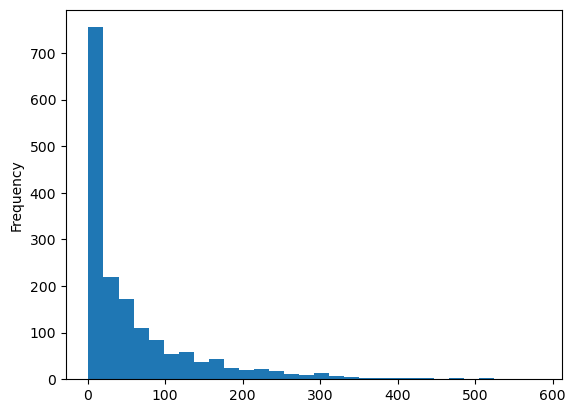

In [9]:
items['popularity'].plot.hist(bins=30);

In [10]:
(items['popularity'] == 1).sum() # Number of movies with only one rating

141

In [11]:
items.nlargest(10, 'popularity')['title'] # Get the 10 most popular movies

49                  Star Wars (1977)
257                   Contact (1997)
99                      Fargo (1996)
180        Return of the Jedi (1983)
293                 Liar Liar (1997)
285      English Patient, The (1996)
287                    Scream (1996)
0                   Toy Story (1995)
299             Air Force One (1997)
120    Independence Day (ID4) (1996)
Name: title, dtype: object

In [12]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.describe()

,item_id,popularity,release_date,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,100000.000000,99991,0.0,99991.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,168.071900,1988-02-09 00:43:11.369223296,NaN,1987.956216,462.48475,3.529860,8.835289e+08
min,1.000000,1.000000,1922-01-01 00:00:00,NaN,1922.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,71.000000,1986-01-01 00:00:00,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,145.000000,1994-01-01 00:00:00,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,239.000000,1996-09-28 00:00:00,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,583.000000,1998-10-23 00:00:00,NaN,1998.000000,943.00000,5.000000,8.932866e+08
std,330.798356,121.784558,NaN,NaN,14.155523,266.61442,1.125674,5.343856e+06


In [13]:
indexed_items = items.set_index('item_id')

In [14]:
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,308,4,887736532
1,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,287,5,875334088
2,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,148,4,877019411
3,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,280,4,891700426
4,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,66,3,883601324


**Quick Exercise**:

As we have seen, the `groupby` method is a powerful tool to quickly compute statistics on the data. Use it to compute the average rating for each movie.

**Hint**: you can use the `mean` method after the `groupby` method.

In [15]:
#try:
all_ratings.groupby('title')['rating'].mean()
#except:
#    raise NotImplementedError("Please calculate the average rating for each movie")

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: rating, Length: 1664, dtype: float64

In [16]:
all_ratings

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,308,4,887736532
1,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,287,5,875334088
2,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,148,4,877019411
3,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,280,4,891700426
4,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,66,3,883601324
...,...,...,...,...,...,...,...,...,...,...
99995,1678,1,Mat' i syn (1997),1998-02-06,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,1998.0,863,1,889289570
99996,1679,1,B. Monkey (1998),1998-02-06,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,1998.0,863,3,889289491
99997,1680,1,Sliding Doors (1998),1998-01-01,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),1998.0,863,2,889289570
99998,1681,1,You So Crazy (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,1994.0,896,3,887160722


Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

In [17]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Explicit feedback: supervised ratings prediction

Now let's begin to do some recommendation! We will build a model that takes a user and a movie as input and outputs a predicted rating. We will be taking advantage of embeddings to represent users and movies. That means that each movie and user will have an abstract representation in a continuous vector space. The model will learn these representations based on the ratings.

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="https://raw.githubusercontent.com/UofT-DSI/deep_learning/refs/heads/main/01_materials/labs/images/rec_archi_1.svg" style="width: 600px;" />

In [18]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model

2025-10-24 15:56:05.078599: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# For each sample we input the integer identifiers
# of a single user and a single item
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))
        
        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mae')

### Monitoring runs

When training a model with Keras, we get a `history` object back that contains lots of information about the training run. We can use this to plot the training and validation loss to see how the model has improved during training.

In [20]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.3111 - val_loss: 1.0443
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9055 - val_loss: 0.7936
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7522 - val_loss: 0.7705
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7248 - val_loss: 0.7577
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7030 - val_loss: 0.7505
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6827 - val_loss: 0.7438
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6606 - val_loss: 0.7408
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6418 - val_loss: 0.7372
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6169 - val_loss: 0.7329
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5945 - val_loss: 0.7371
CPU times: user 45.9 s, sys: 7.18 s, total: 53 s
Wall time: 31.1 s


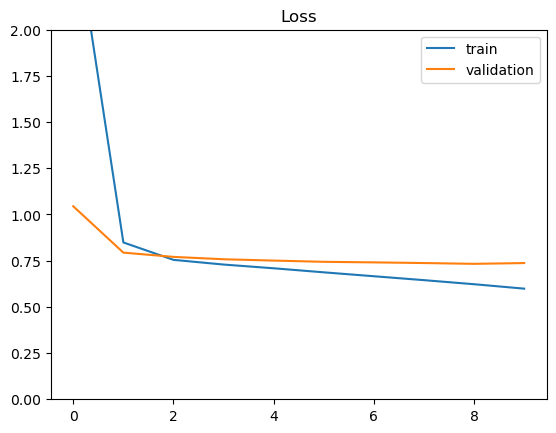

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

**Questions**:

- Does it look like our model has overfit? Why or why not?  
Your Answer: ____________ Yes the model has overfit.
- Suggest something we could do to prevent overfitting.  
Your Answer: ____________ Ways to prevent overfitting: (1) limit numbers of features; (2) use Lasso Regress (L1) or Ridge Regression (L2) to penalize large coefficients; (3) do cross-validation; (4) train with more data

Now that the model is trained, let's check out the quality of predictions:

In [22]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final test MSE: 0.906
Final test MAE: 0.736


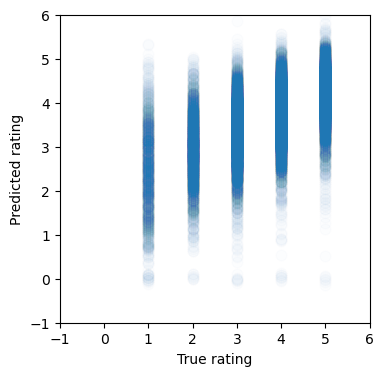

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

This graph shows us the range of predicted ratings our model gives, organized by the true rating. We can see that generally, the higher the true rating the higher the predicted rating, although there is quite a range of predictions for each instance. That's okay - our model is very simple, and human preferences are very complex!

Taking a look at the Mean Absolute Error, hopefully you got something around 0.75. This means that, on average, our predicted ratings are about 0.75 stars off from the true ratings. This is a pretty good result for a first attempt. We could probably do better with a more complex model, but we'll leave that for another time.

### Model Embeddings

Our model was built with two embedding layers. These layers have learned a representation of both the users and the movies in our dataset. We can extract these representations and use them to find similar movies or users. We can also do interesting exploratory analysis, like finding the most popular movies among our users, or finding the users that are most interested in a given movie.

In [24]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 64), (1683, 64)]

In [25]:
user_embeddings = weights[0]
item_embeddings = weights[1]

In [26]:
item_id = 181
print(f"Title for item_id={item_id}: {indexed_items['title'][item_id]}")

Title for item_id=181: Return of the Jedi (1983)


In [27]:
print(f"Embedding vector for item_id={item_id}")
print(item_embeddings[item_id])
print("shape:", item_embeddings[item_id].shape)

Embedding vector for item_id=181
[ 0.4043006  -0.46576053 -0.41201    -0.5123362   0.1427734   0.05529338
  0.43121672  0.2747947  -0.44782472  0.48078316 -0.26469493 -0.39281967
 -0.28335914 -0.29818586 -0.22879064  0.35764414 -0.5449413   0.18419625
 -0.41312125  0.20004223  0.06521795 -0.36736786 -0.4271869  -0.35746855
 -0.3030848  -0.06963085  0.29508913 -0.32106605 -0.29901922  0.25021625
  0.5066933  -0.31691352 -0.2279335   0.00236036 -0.121933    0.39667067
 -0.28291526  0.2007897  -0.31313896  0.22807372 -0.23045547 -0.43747893
  0.13862555 -0.49253085 -0.33964214 -0.22405668  0.51168346  0.41565752
 -0.11841061 -0.46763507  0.02641347  0.3533699  -0.18308619 -0.03316131
  0.25712872 -0.2510615   0.35013884  0.5665104   0.1992388  -0.27672854
 -0.23991992 -0.10851135 -0.13696977  0.29862353]
shape: (64,)


As we discussed in lecture, our embeddings are not directly interpretable - we can't look at, say, a value of 0.297 in the embedding vector and say "this means that the movie is a drama". As an aside, there is a field of research dedicated to making _interpretable_ embeddings, but it's not something we'll cover in this course. 

### Finding our most similar items

Now we can have some fun, investigating the embeddings we've learned. We can start by finding the most similar items to a given item. We can do this by computing the cosine similarity between the item's embedding and the embedding of every other item. We can use the `cosine_similarity` function from `sklearn` to do this.

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine(a, b):
    # Reshape to the shape our function expects
    a = a.reshape(1, -1)
    b = b.reshape(1, -1)
    return cosine_similarity(a, b)[0, 0]

In [29]:
def print_similarity(item_a, item_b, item_embeddings, titles):
    print(titles[item_a])
    print(titles[item_b])
    similarity = cosine(item_embeddings[item_a],
                        item_embeddings[item_b])
    print(f"Cosine similarity: {similarity:.3}")
    
print_similarity(50, 181, item_embeddings, indexed_items["title"])

Star Wars (1977)
Return of the Jedi (1983)
Cosine similarity: 0.899


It makes sense that the original Star Wars, and its later sequel Return of the Jedi have a high similarity. Let's try some other examples:

In [30]:
print_similarity(181, 288, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Scream (1996)
Cosine similarity: 0.69


In [31]:
print_similarity(181, 1, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Toy Story (1995)
Cosine similarity: 0.782


In [32]:
print_similarity(181, 181, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Return of the Jedi (1983)
Cosine similarity: 1.0


*Quick Exercise*:

- Find some other films and compare their similarity. Do the results make sense to you? Can you find a pair of films that are very _dissimilar_?

In [33]:
# Code to help you search for a movie title
partial_title = "Jedi"
indexed_items[indexed_items['title'].str.contains(partial_title)]

#raise NotImplementedError("Please implement the next steps yourself")

,popularity,title,release_date,video_release_date,imdb_url,release_year
item_id,,,,,,
181,507,Return of the Jedi (1983),1997-03-14,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997.0


Sometimes, even without knowing anything about a user, we can recommend films by asking them about a film that they do like. The code below compares the similarity of a given film to all others, and returns the most similar films.

In [34]:
def most_similar(item_id, item_embeddings, titles,
                 top_n=30):
    # Compute the cosine similarity between the item and all other items
    sims = cosine_similarity(item_embeddings[item_id].reshape(1, -1),
                             item_embeddings).ravel()
    
    # [::-1] makes it possible to reverse the order of a numpy
    # array, this is required because most similar items have
    # a larger cosine similarity value
    sorted_indexes = np.argsort(sims)[::-1]
    idxs = sorted_indexes[0:top_n]
    return list(zip(idxs, titles[idxs], sims[idxs]))

# Find the most similar films to "Star Wars"
most_similar(50, item_embeddings, indexed_items["title"], top_n=10)

[(50, 'Star Wars (1977)', 1.0000001),
 (174, 'Raiders of the Lost Ark (1981)', 0.91453356),
 (181, 'Return of the Jedi (1983)', 0.89922976),
 (172, 'Empire Strikes Back, The (1980)', 0.89666486),
 (12, 'Usual Suspects, The (1995)', 0.88105965),
 (194, 'Sting, The (1973)', 0.8652962),
 (1576, 'Hungarian Fairy Tale, A (1987)', 0.8619123),
 (96, 'Terminator 2: Judgment Day (1991)', 0.8601094),
 (298, 'Face/Off (1997)', 0.8552545),
 (98, 'Silence of the Lambs, The (1991)', 0.850886)]

In [35]:
# Find the most similar films to "Star Trek VI: The Undiscovered Country"
most_similar(227, item_embeddings, indexed_items["title"], top_n=10)

[(227, 'Star Trek VI: The Undiscovered Country (1991)', 1.0),
 (230, 'Star Trek IV: The Voyage Home (1986)', 0.9205755),
 (674, 'Cat People (1982)', 0.903497),
 (183, 'Alien (1979)', 0.9025951),
 (163, 'Return of the Pink Panther, The (1974)', 0.89768577),
 (963, 'Some Folks Call It a Sling Blade (1993)', 0.8937806),
 (267, 'unknown', 0.8902863),
 (1285, 'Princess Caraboo (1994)', 0.88951254),
 (1485, 'Colonel Chabert, Le (1994)', 0.88637304),
 (726, 'Fluke (1995)', 0.8852246)]

The similarities do not always make sense: the number of ratings is low and the embedding  does not automatically capture semantic relationships in that context. Better representations arise with higher number of ratings, and less overfitting  in models or maybe better loss function, such as those based on implicit feedback.

### Visualizing embeddings using TSNE

The [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm enables us to visualize high dimensional vectors in a 2D space by preserving local neighborhoods. We can use it to get a 2D visualization of the item embeddings and see if similar items are close in the embedding space.

In [36]:
from sklearn.manifold import TSNE

item_tsne = TSNE(learning_rate="auto", init="pca", perplexity=30).fit_transform(item_embeddings)

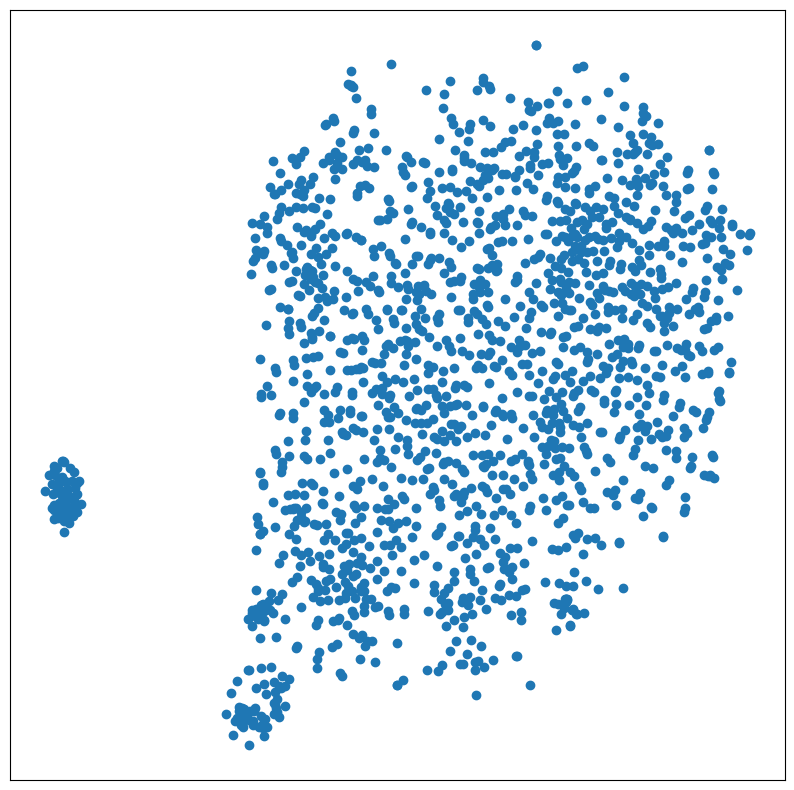

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [38]:
import plotly.express as px

tsne_df = pd.DataFrame(item_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["item_id"] = np.arange(item_tsne.shape[0])
tsne_df = tsne_df.merge(items.reset_index())

px.scatter(tsne_df, x="tsne_1", y="tsne_2",
           color="popularity",
           hover_data=["item_id", "title", "popularity"])

### Exercises

 - Add another layer to the neural network and retrain, compare train/test error.
 - Try adding more dropout and change layer sizes.


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user that they haven't seen before. The following code does that.

- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a function that sorts these items and excludes those the user has already seen.

In [39]:
def recommend(user_id, top_n=10):
    item_ids = range(1, items['item_id'].max())
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    user = np.zeros_like(item_ids)
    user[:len(item_ids)] = user_id
    items_ = np.array(item_ids)
    ratings = model.predict([user, items_]).flatten()
    top_items = ratings.argsort()[-top_n:][::-1]
    return [(indexed_items.loc[item_id]["title"], ratings[item_id]) for item_id in top_items]

In [40]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
    4.5: 20,000 Leagues Under the Sea (1954)
    4.3: Eat Drink Man Woman (1994)
    4.3: Dead Man Walking (1995)
    4.3: Terminator 2: Judgment Day (1991)
    4.3: Color of Night (1994)
    4.2: Get Shorty (1995)
    4.1: Jude (1996)
    4.1: Letter From Death Row, A (1998)
    4.1: Robert A. Heinlein's The Puppet Masters (1994)
    4.1: Faster Pussycat! Kill! Kill! (1965)


### Exercises

- Try modifying our neural network to improve recommendation. You could try adding more layers, or using a different loss function. 
- Your goal is to improve the Mean Absolute Error on the test set. Show the results of your best model.

In [ ]:
# Extend and improve the model below

# model_1: 1 dense layer per tower

from tensorflow.keras.layers import Dense

class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')
        
        self.user_dense = Dense(embedding_size, activation='relu')
        self.item_dense = Dense(embedding_size, activation='relu')

        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_dense(self.user_embedding(user_inputs)))
        item_vecs = self.flatten(self.item_dense(self.item_embedding(item_inputs)))

        y = self.dot([user_vecs, item_vecs])
        return y

model_1 = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model_1.compile(optimizer="adam", loss='mae')

In [42]:
# Training the model_1
history_1 = model_1.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.4531 - val_loss: 0.7572
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7417 - val_loss: 0.7443
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7079 - val_loss: 0.7358
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6870 - val_loss: 0.7492
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6548 - val_loss: 0.7379
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6202 - val_loss: 0.7501
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5899 - val_loss: 0.7556
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5625 - val_loss: 0.7643
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5402 - val_loss: 0.7711
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.5174 - val_loss: 0.7760


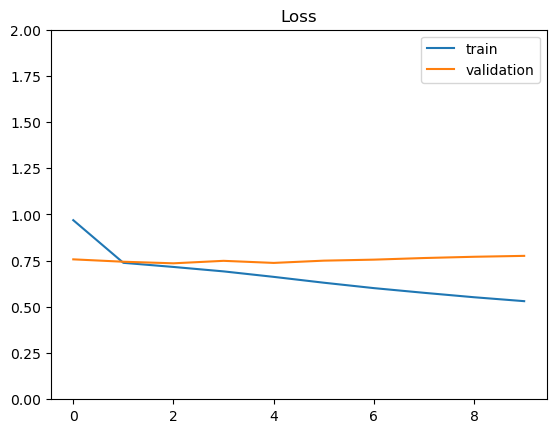

In [43]:
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [44]:
test_preds_1 = model_1.predict([user_id_test, item_id_test])
mae_1 = mean_absolute_error(test_preds_1, rating_test)
print("model_1 mae: %0.3f" % mae_1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
model_1 mae: 0.771


In [ ]:
# model_2: Same as model_1 + sigmoid

import tensorflow as tf

class RegressionModelSigmoid(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')
        
        self.user_dense = Dense(embedding_size, activation='relu')
        self.item_dense = Dense(embedding_size, activation='relu')

        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_dense(self.user_embedding(user_inputs)))
        item_vecs = self.flatten(self.item_dense(self.item_embedding(item_inputs)))

        y = self.dot([user_vecs, item_vecs])
        return tf.sigmoid(y) * 4 + 1

model_2 = RegressionModelSigmoid(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model_2.compile(optimizer="adam", loss='mae')

In [46]:
# Training the model_2
history_2 = model_2.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8572 - val_loss: 0.7684
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7436 - val_loss: 0.7551
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7196 - val_loss: 0.7496
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7004 - val_loss: 0.7497
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6848 - val_loss: 0.7514
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6704 - val_loss: 0.7524
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6535 - val_loss: 0.7544
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6372 - val_loss: 0.7590
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6275 - val_loss: 0.7632
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6131 - val_loss: 0.7669


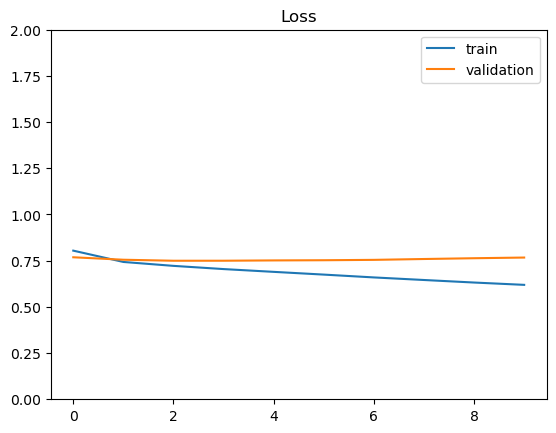

In [47]:
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [48]:
test_preds_2 = model_2.predict([user_id_test, item_id_test])
mae_2 = mean_absolute_error(test_preds_2, rating_test)
print("model_2 mae: %0.3f" % mae_2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
model_2 mae: 0.771


In [ ]:
# model_3: 2 dense layers per tower + sigmoid

class RegressionModelSigmoid_2(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')
        
        self.user_dense1 = Dense(embedding_size, activation='relu')
        self.item_dense1 = Dense(embedding_size, activation='relu')

        self.user_dense2 = Dense(embedding_size, activation='relu')
        self.item_dense2 = Dense(embedding_size, activation='relu')

        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.user_embedding(user_inputs)
        user_vecs = self.user_dense1(user_vecs)
        user_vecs = self.user_dense2(user_vecs)
        user_vecs = self.flatten(user_vecs)

        item_vecs = self.item_embedding(item_inputs)
        item_vecs = self.item_dense1(item_vecs)
        item_vecs = self.item_dense2(item_vecs)
        item_vecs = self.flatten(item_vecs)

        y = self.dot([user_vecs, item_vecs])
        return tf.sigmoid(y) * 4 + 1

model_3 = RegressionModelSigmoid_2(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model_3.compile(optimizer="adam", loss='mae')

In [50]:
# Training the model_3
history_3 = model_3.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.8434 - val_loss: 0.7753
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.7452 - val_loss: 0.7645
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.7275 - val_loss: 0.7488
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.7048 - val_loss: 0.7432
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.6943 - val_loss: 0.7445
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.6876 - val_loss: 0.7457
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.6808 - val_loss: 0.7474
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.6800 - val_loss: 0.7452
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6708 - val_loss: 0.7481
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.6659 - val_loss: 0.7527


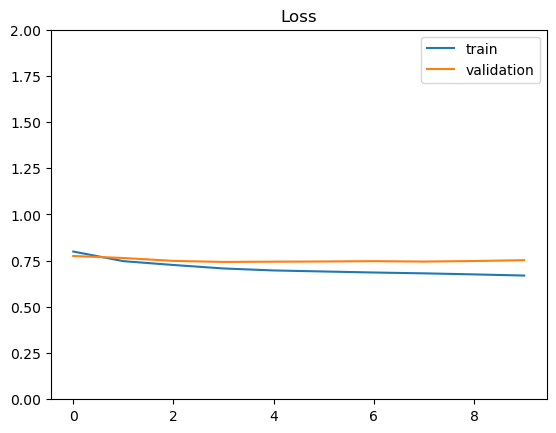

In [51]:
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [52]:
test_preds_3 = model_3.predict([user_id_test, item_id_test])
mae_3 = mean_absolute_error(test_preds_3, rating_test)
print("model_3 mae: %0.3f" % mae_3)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
model_3 mae: 0.755


In [ ]:
# model_4: Same as model_3 without sigmoid

class RegressionModel_2(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')
        
        self.user_dense1 = Dense(embedding_size, activation='relu')
        self.item_dense1 = Dense(embedding_size, activation='relu')

        self.user_dense2 = Dense(embedding_size, activation='relu')
        self.item_dense2 = Dense(embedding_size, activation='relu')

        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.user_embedding(user_inputs)
        user_vecs = self.user_dense1(user_vecs)
        user_vecs = self.user_dense2(user_vecs)
        user_vecs = self.flatten(user_vecs)

        item_vecs = self.item_embedding(item_inputs)
        item_vecs = self.item_dense1(item_vecs)
        item_vecs = self.item_dense2(item_vecs)
        item_vecs = self.flatten(item_vecs)

        y = self.dot([user_vecs, item_vecs])
        return y

model_4 = RegressionModel_2(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model_4.compile(optimizer="adam", loss='mae')

In [54]:
# Training the model_4
history_4 = model_4.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.1818 - val_loss: 0.7670
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.7545 - val_loss: 0.7499
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7298 - val_loss: 0.7467
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7143 - val_loss: 0.7466
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6885 - val_loss: 0.7570
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6687 - val_loss: 0.7442
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6478 - val_loss: 0.7515
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6237 - val_loss: 0.7521
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6024 - val_loss: 0.7553
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5862 - val_loss: 0.7647


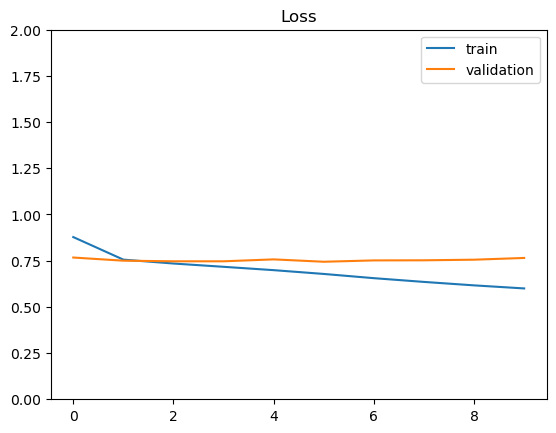

In [55]:
plt.plot(history_4.history['loss'], label='train')
plt.plot(history_4.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [56]:
test_preds_4 = model_4.predict([user_id_test, item_id_test])
mae_4 = mean_absolute_error(test_preds_4, rating_test)
print("model_4 mae: %0.3f" % mae_4)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
model_4 mae: 0.759


In [ ]:
# model_5: Same as model_3 with tanh

class RegressionModel_tanh(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')
        
        self.user_dense1 = Dense(embedding_size, activation='relu')
        self.item_dense1 = Dense(embedding_size, activation='relu')

        self.user_dense2 = Dense(embedding_size, activation='relu')
        self.item_dense2 = Dense(embedding_size, activation='relu')

        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.user_embedding(user_inputs)
        user_vecs = self.user_dense1(user_vecs)
        user_vecs = self.user_dense2(user_vecs)
        user_vecs = self.flatten(user_vecs)

        item_vecs = self.item_embedding(item_inputs)
        item_vecs = self.item_dense1(item_vecs)
        item_vecs = self.item_dense2(item_vecs)
        item_vecs = self.flatten(item_vecs)

        y = self.dot([user_vecs, item_vecs])
        y = tf.tanh(y) * 2 + 3

        return y

model_5 = RegressionModel_tanh(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model_5.compile(optimizer="adam", loss='mae')

In [58]:
# Training the model_5
history_5 = model_5.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.8396 - val_loss: 0.7625
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.7439 - val_loss: 0.7506
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7217 - val_loss: 0.7489
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7075 - val_loss: 0.7433
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6907 - val_loss: 0.7448
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6899 - val_loss: 0.7470
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6834 - val_loss: 0.7477
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6790 - val_loss: 0.7490
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6652 - val_loss: 0.7538
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6581 - val_loss: 0.7586


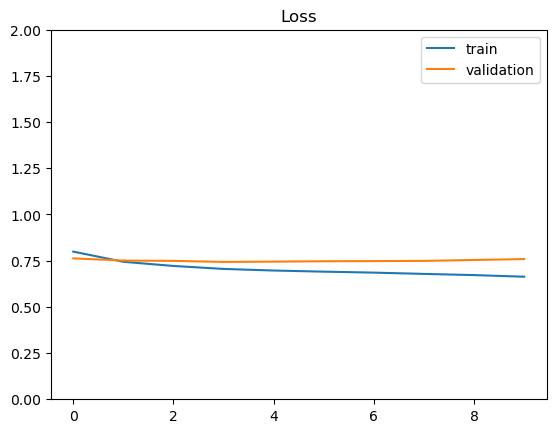

In [59]:
plt.plot(history_5.history['loss'], label='train')
plt.plot(history_5.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [60]:
test_preds_5 = model_5.predict([user_id_test, item_id_test])
mae_5 = mean_absolute_error(test_preds_5, rating_test)
print("model_5 mae: %0.3f" % mae_5)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
model_5 mae: 0.757


In [ ]:
# model_6: Same as model_4 + dropout (rate=0.5)   

from tensorflow.keras.layers import Dropout

class RegressionModel_dropout(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id, dropout_rate=0.5):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')
        
        self.user_dense1 = Dense(embedding_size, activation='relu')
        self.user_dropout1 = Dropout(dropout_rate)
        self.user_dense2 = Dense(embedding_size, activation='relu')
        self.user_dropout2 = Dropout(dropout_rate)

        self.item_dense1 = Dense(embedding_size, activation='relu')
        self.item_dropout1 = Dropout(dropout_rate)
        self.item_dense2 = Dense(embedding_size, activation='relu')
        self.item_dropout2 = Dropout(dropout_rate)

        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.user_embedding(user_inputs)
        user_vecs = self.user_dense1(user_vecs)
        user_vecs = self.user_dropout1(user_vecs, training=training)
        user_vecs = self.user_dense2(user_vecs)
        user_vecs = self.user_dropout2(user_vecs, training=training)
        user_vecs = self.flatten(user_vecs)

        item_vecs = self.item_embedding(item_inputs)
        item_vecs = self.item_dense1(item_vecs)
        item_vecs = self.item_dropout1(item_vecs, training=training)
        item_vecs = self.item_dense2(item_vecs)
        item_vecs = self.item_dropout2(item_vecs, training=training)
        item_vecs = self.flatten(item_vecs)

        y = self.dot([user_vecs, item_vecs])

        return y

model_6 = RegressionModel_dropout(
    embedding_size=64, 
    max_user_id=all_ratings['user_id'].max(), 
    max_item_id=all_ratings['item_id'].max(),
    dropout_rate=0.5)
model_6.compile(optimizer="adam", loss='mae')

In [62]:
# Training the model_6
history_6 = model_6.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 1.5086 - val_loss: 0.7856
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0429 - val_loss: 0.7963
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0210 - val_loss: 0.7995
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0125 - val_loss: 0.8010
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0057 - val_loss: 0.7875
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0116 - val_loss: 0.8051
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.0081 - val_loss: 0.8093
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0080 - val_loss: 0.7833
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9980 - val_loss: 0.7817
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0002 - val_loss: 0.7938


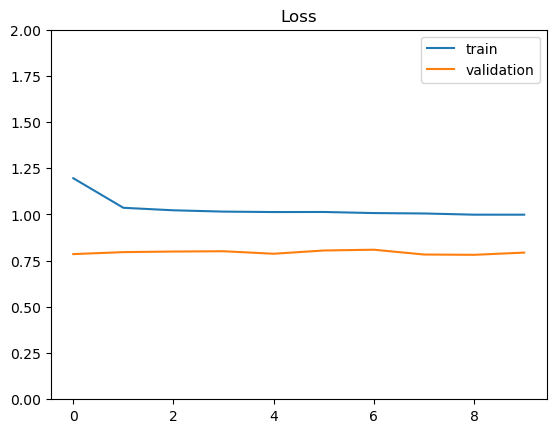

In [63]:
plt.plot(history_6.history['loss'], label='train')
plt.plot(history_6.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [64]:
test_preds_6 = model_6.predict([user_id_test, item_id_test])
mae_6 = mean_absolute_error(test_preds_6, rating_test)
print("model_6 mae: %0.3f" % mae_6)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
model_6 mae: 0.787


In [ ]:
# model_7: Same as model_6 but with dropout (rate=0.2) 

model_7 = RegressionModel_dropout(
    embedding_size=64,
    max_user_id=all_ratings['user_id'].max(),
    max_item_id=all_ratings['item_id'].max(),
    dropout_rate=0.2  # ← new rate here
)

model_7.compile(optimizer="adam", loss='mae')

# Training the model_7
history_7 = model_7.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.2689 - val_loss: 0.7664
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8333 - val_loss: 0.7604
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.8174 - val_loss: 0.7514
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.8007 - val_loss: 0.7728
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7981 - val_loss: 0.7436
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7912 - val_loss: 0.7444
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7866 - val_loss: 0.7416
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7825 - val_loss: 0.7362
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7785 - val_loss: 0.7387
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.7761 - val_loss: 0.7338


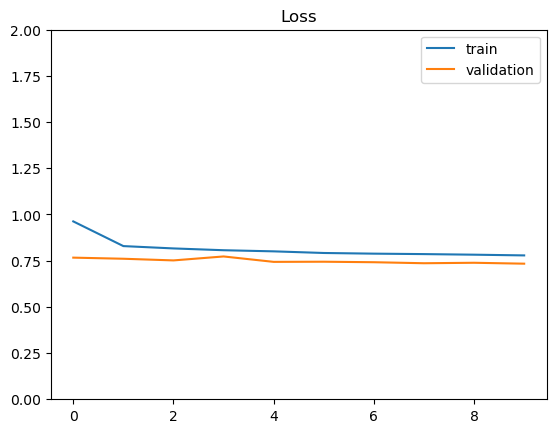

In [67]:
plt.plot(history_7.history['loss'], label='train')
plt.plot(history_7.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [68]:
test_preds_7 = model_7.predict([user_id_test, item_id_test])
mae_7 = mean_absolute_error(test_preds_7, rating_test)
print("model_7 mae: %0.3f" % mae_7)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
model_7 mae: 0.730


In [69]:
# model.summary() is a great tool to inspect the flow of data through the model, and helps 
# to verify that each layer’s output is properly connected to the next layer.

model.summary()

Model: "regression_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ (64, 64)               │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding (Embedding)      │ (64, 64)               │       107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot (Dot)                       │ (64, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,386 (1.92 MB)

 Trainable params: 168,128 (656.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 336,258 (1.28 MB)

In [70]:
model_1.summary()

Model: "regression_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ (64, 64)               │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding (Embedding)      │ (64, 64)               │       107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot_1 (Dot)                     │ (64, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,346 (2.02 MB)

 Trainable params: 176,448 (689.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 352,898 (1.35 MB)

In [71]:
model_2.summary()

Model: "regression_model_sigmoid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ (64, 64)               │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding (Embedding)      │ (64, 64)               │       107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot_2 (Dot)                     │ (64, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,346 (2.02 MB)

 Trainable params: 176,448 (689.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 352,898 (1.35 MB)

In [72]:
model_3.summary()

Model: "regression_model_sigmoid_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ (64, 64)               │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding (Embedding)      │ (64, 64)               │       107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot_3 (Dot)                     │ (64, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,306 (2.11 MB)

 Trainable params: 184,768 (721.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,538 (1.41 MB)

In [73]:
model_4.summary()

Model: "regression_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ (64, 64)               │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding (Embedding)      │ (64, 64)               │       107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot_4 (Dot)                     │ (64, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,306 (2.11 MB)

 Trainable params: 184,768 (721.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,538 (1.41 MB)

In [74]:
model_5.summary()

Model: "regression_model_tanh"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ (64, 64)               │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding (Embedding)      │ (64, 64)               │       107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot_5 (Dot)                     │ (64, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,306 (2.11 MB)

 Trainable params: 184,768 (721.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,538 (1.41 MB)

In [75]:
model_6.summary()

Model: "regression_model_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ (64, 64)               │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding (Embedding)      │ (64, 64)               │       107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot_6 (Dot)                     │ (64, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,306 (2.11 MB)

 Trainable params: 184,768 (721.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,538 (1.41 MB)

In [76]:
model_7.summary()

Model: "regression_model_dropout_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding (Embedding)      │ (64, 64)               │        60,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding (Embedding)      │ (64, 64)               │       107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot_7 (Dot)                     │ (64, 1)                │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,306 (2.11 MB)

 Trainable params: 184,768 (721.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,538 (1.41 MB)

In [78]:
# gather summary data

mae = mean_absolute_error(test_preds, rating_test)

models = [model, model_1, model_2, model_3, model_4, model_5, model_6, model_7]
histories = [history, history_1, history_2, history_3, history_4, history_5, history_6, history_7]
predictions = [test_preds, test_preds_1, test_preds_2, test_preds_3, test_preds_4, test_preds_5, test_preds_6, test_preds_7]
maes = [mae, mae_1, mae_2, mae_3, mae_4, mae_5, mae_6, mae_7]

for i in range(8):
    label = "baseline" if i == 0 else f"model_{i}"
    print(f"\n{label}")
    print("First 10 predictions:", predictions[i][:10].flatten())

for i in range(8):
    label = "baseline" if i == 0 else f"model_{i}"
    print(f"\n{label}")
    print("MAE:", maes[i])

for i in range(8):
    label = "baseline" if i == 0 else f"model_{i}"
    print(f"\n{label}")
    print("Final training loss:", histories[i].history['loss'][-1])


baseline
First 10 predictions: [5.366036  4.0959697 1.9250007 3.0965555 2.1134586 3.6303642 2.7728443
 3.300932  3.5808947 4.2407513]

model_1
First 10 predictions: [4.9214354 3.8156173 3.08768   3.3132489 2.9793534 3.9440205 1.7470689
 3.511801  3.677185  4.381656 ]

model_2
First 10 predictions: [4.9999995 3.5416517 3.        3.0941012 3.        3.8366647 3.1500256
 3.485127  3.006256  4.313822 ]

model_3
First 10 predictions: [5.        3.8959908 3.        3.2766562 3.        4.148775  3.
 3.        4.087512  4.079524 ]

model_4
First 10 predictions: [5.175197  3.6388867 2.3146172 3.2248335 2.1886227 4.0676503 2.96061
 4.1753573 3.9883742 5.0657954]

model_5
First 10 predictions: [5.        3.9171953 3.        3.1507201 3.        3.814829  3.
 3.        4.0853815 3.863206 ]

model_6
First 10 predictions: [4.7098823 3.2321227 2.929732  3.2024155 1.487296  3.1777217 3.2560573
 3.4299908 3.5310555 3.5621903]

model_7
First 10 predictions: [4.586161  3.6644318 2.3526735 3.55845   1.629

# Recommender System Model Comparison Summary

This section summarizes the performance of eight recommender system models, including a baseline and seven variations. Each model was evaluated using Mean Absolute Error (MAE), final training loss, and a sample of the first 10 predictions.


## Model Overview

| Model      | Architecture Summary                            |
|------------|--------------------------------------------------|
| baseline   | Raw dot product of user/item embeddings         |
| model_1    | 1 dense layer per tower                         |
| model_2    | Same as model_1 + sigmoid               |
| model_3    | 2 dense layers per tower + sigmoid              |
| model_4    | Same as model_3 without sigmoid                 |
| model_5    | Same as model_3 with tanh                       |
| model_6    | Same as model_4 + dropout (rate=0.5)            |
| model_7    | Same as model_6 but with dropout (rate=0.2)     |


## MAE Comparison

| Model      | MAE     |
|------------|---------|
| baseline   | 0.7361  |
| model_1    | 0.7714  |
| model_2    | 0.7715  |
| model_3    | 0.7553  |
| model_4    | 0.7591  |
| model_5    | 0.7569  |
| model_6    | 0.7866  |
| **model_7**| **0.7300** |


## Final Training Loss

| Model      | Final Training Loss |
|------------|---------------------|
| baseline   | 0.5987              |
| model_1    | 0.5309              |
| model_2    | 0.6192              |
| model_3    | 0.6695              |
| model_4    | 0.5998              |
| model_5    | 0.6633              |
| model_6    | 0.9989              |
| model_7    | 0.7785              |


## First 10 Predictions (Rounded)

| Model      | Predictions |
|------------|-------------|
| baseline   | [5.37, 4.10, 1.93, 3.10, 2.11, 3.63, 2.77, 3.30, 3.58, 4.24] |
| model_1    | [4.92, 3.82, 3.09, 3.31, 2.98, 3.94, 1.75, 3.51, 3.68, 4.38] |
| model_2    | [5.00, 3.54, 3.00, 3.09, 3.00, 3.84, 3.15, 3.49, 3.01, 4.31] |
| model_3    | [5.00, 3.90, 3.00, 3.28, 3.00, 4.15, 3.00, 3.00, 4.09, 4.08] |
| model_4    | [5.18, 3.64, 2.31, 3.22, 2.19, 4.07, 2.96, 4.18, 3.99, 5.07] |
| model_5    | [5.00, 3.92, 3.00, 3.15, 3.00, 3.81, 3.00, 3.00, 4.09, 3.86] |
| model_6    | [4.71, 3.23, 2.93, 3.20, 1.49, 3.18, 3.26, 3.43, 3.53, 3.56] |
| **model_7**| [4.59, 3.66, 2.35, 3.56, 1.63, 3.86, 2.75, 3.70, 3.61, 4.04] |


## Key Insights

- **Model 7** achieved the best MAE despite having a higher training loss — dropout helped generalization.
- **Model 6** had the worst performance due to excessive dropout (underfitting).
- **Baseline model** performed surprisingly well, nearly matching Model 7.
- **Sigmoid and tanh** activations (models 2, 3, 5) tended to make predictions around 3.0.
- **More complex architectures** helped slightly but didn’t outperform the baseline without regularization.